In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFCS_bmimPF6_PR import configuration

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [4]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [6]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(298.15)
m.fs.F101.inlet.pressure.fix(250000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(298.15)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [7]:
m.fs.F101.initialize(outlvl=idaeslog.INFO_HIGH)

2021-03-13 21:58:33 [INFO] idaes.init.fs.F101.control_volume.properties_in: Starting initialization
2021-03-13 21:58:33 [INFO] idaes.init.fs.F101.control_volume.properties_in: Dew and bubble point initialization: optimal - Optimal Solution Found.
2021-03-13 21:58:33 [INFO] idaes.init.fs.F101.control_volume.properties_in: Equilibrium temperature initialization completed.
2021-03-13 21:58:33 [INFO] idaes.init.fs.F101.control_volume.properties_in: State variable initialization completed.
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
2021-03-13 21:58:34 [INFO] idaes.init.fs.F101.control_volume.properties_in: Phase equilibrium initialization: infeasible - Converged to a locally infeasible point. Problem may be infeasible..
    model.name="SimpleBlock";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Conv

In [8]:
result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [9]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 15565. : False : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000       1.0000    1.5560e-10  
    mole_frac_comp bmimPF6  0.0010000   1.0000e-08       0.86459  
    mole_frac_comp R32        0.50000      0.50000      0.097465  
    mole_frac_comp R125       0.50000      0.50000      0.037949  
    temperature                298.15       298.15        298.15  
    pressure               2.5000e+05   2.5000e+05    2.5000e+05  


In [10]:
IL_z = np.linspace(0.1, 0.99, 5)
IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

m.fs.props.PR_kappa['R32', 'R125'].fix(-0.002535)
m.fs.props.PR_kappa['R125', 'R32'].fix(-0.002535)
# m.fs.props.PR_kappa['R32', 'bmimPF6'].fix(-0.01435)
# m.fs.props.PR_kappa['bmimPF6', 'R32'].fix(0.9651)
# m.fs.props.PR_kappa['bmimPF6', 'R125'].fix(0.6312)
# m.fs.props.PR_kappa['R125', 'bmimPF6'].fix(0.0504)

m.fs.props.PR_kappa['R32', 'bmimPF6'].fix(-0.05102)
m.fs.props.PR_kappa['bmimPF6', 'R32'].fix(0.2839)
m.fs.props.PR_kappa['bmimPF6', 'R125'].fix(1.6929)
m.fs.props.PR_kappa['R125', 'bmimPF6'].fix(0.04738)

for j in range(len(IL_z)):

    fract = 1 - IL_z[j]
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.2*IL_z[j])
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.2*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.8)   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        print(j,'Feasible.')
    else:
        print(j,'Infeasible.')

    

0 Feasible.
1 Feasible.
2 Feasible.
3 Feasible.
4 Feasible.


In [11]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i], R32_x[i], R125_x[i])
    points_x.append(points)
    
# print(points_x)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i], R32_y[i], R125_y[i])
    points_y.append(points)
    
# print(points_y)

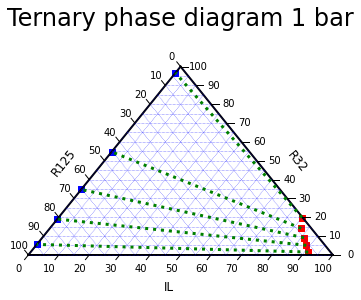

In [12]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i]*100, R32_x[i]*100, R125_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i]*100, R32_y[i]*100, R125_y[i]*100)
    points_y.append(points)

import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram 1 bar\n", fontsize=24)
tax.left_axis_label("R125", fontsize=fontsize, offset=offset)
tax.right_axis_label("R32", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

for i in range(len(IL_z)):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")

tax.scatter(points_x, marker='s', color='red', label="liquid")
tax.scatter(points_y, marker='s', color='blue', label="vapor")


tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()

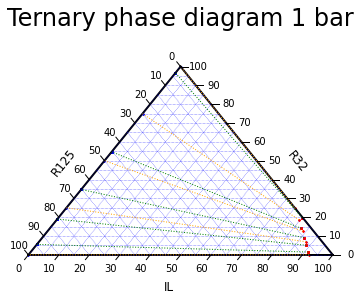

In [13]:
IL_xd = [0.753218088,0.79638503,0.838841522,0.877745764,0.92256095]
R32_xd = [0.246781912,0.18571163,0.125550724,0.06948201,-8.5254E-05]
R125_xd = [0,0.01790334,0.035607754,0.052772226,0.077524304]

IL_yd = [0, 0, 0, 0, 0]
R32_yd = [1,0.75,0.5,0.25,0]
R125_yd = [0,0.25,0.5,0.75,1]

scale = 100
figure, tax = ternary.figure(scale=scale)

points_xd = []

for i in range(len(IL_xd)):
    points = (IL_xd[i]*100, R32_xd[i]*100, R125_xd[i]*100)
    points_xd.append(points)

points_yd = []

for i in range(len(IL_xd)):
    points = (IL_yd[i]*100, R32_yd[i]*100, R125_yd[i]*100)
    points_yd.append(points)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram 1 bar\n", fontsize=24)
tax.left_axis_label("R125", fontsize=fontsize, offset=offset)
tax.right_axis_label("R32", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

for i in range(len(IL_z)):
    tax.line(points_x[i], points_y[i], linewidth=1., color='green', linestyle=":")
    
for i in range(len(IL_xd)):
    tax.line(points_xd[i], points_yd[i], linewidth=1., color='orange', linestyle=":")

tax.scatter(points_x, marker='s', color='red', label="liquid",s=2)
tax.scatter(points_y, marker='s', color='blue', label="vapor",s=2)

tax.scatter(points_xd, marker='D', color='red', label="liquid",s=2)
tax.scatter(points_yd, marker='D', color='blue', label="vapor",s=2)


tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.savefig('ter6.pdf')
tax.show()
